# Model Building

This Jupyter Notebook will build different electric demand forcasting models and compare them.

## 1. Loading Data and Libraries

In [250]:
# Importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

sns.set()

In [251]:
# Importing the dataset
df = pd.read_csv('./Data/cleandata/CleanedCT.csv', parse_dates=['ts'], index_col='ts')
df = df.drop(['Unnamed: 0'], axis=1)
df['non_working'] = df.apply(lambda x: True if \
                                         ((x['non_working'] == 'non-working'))
                                         else False, axis = 1)
print('Data Frame Shape:', df.shape)
df.head()

Data Frame Shape: (113976, 14)


,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday,trend,non_working
ts,,,,,,,,,,,,,,
2004-01-01 00:00:00,CT,3126.0,33.0,26.0,2004-01-01,2004,1,0,Thu,1,False,True,7344.0,True
2004-01-01 01:00:00,CT,2945.0,34.0,26.0,2004-01-01,2004,1,1,Thu,1,False,True,7345.0,True
2004-01-01 02:00:00,CT,2804.0,40.0,26.0,2004-01-01,2004,1,2,Thu,1,False,True,7346.0,True
2004-01-01 03:00:00,CT,2729.0,38.0,23.0,2004-01-01,2004,1,3,Thu,1,False,True,7347.0,True
2004-01-01 04:00:00,CT,2722.0,37.0,21.0,2004-01-01,2004,1,4,Thu,1,False,True,7348.0,True


In [252]:
df['day_of_week'] = df['day_of_week'].astype('category')
df['non_working'] = df['non_working'].astype('category')
df['hour'] = df['hour'].astype('category')
df['month'] = df['month'].astype('category')

## 2. Defining Basic Functions

In [253]:
# Creating an empty dict to save all the erros from different models
dict_error = dict()

In [254]:
# creating function for plotting predicted vs actual energy values
def PredTrueReg(pred, truth, model_name=None):
    """
    Plots the observed energy consumption against the predicted energy consumption
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.scatter(truth, pred, alpha=0.7) 
    plt.xlabel("Observed Electric Consumption (MwH)")
    plt.ylabel("Predicted Electric Consumption (MwH)")
    plt.title(f"Observed VS Predicted Electric Consumption using {model_name}", fontsize=14)

    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color='black')

In [255]:
def error_metrics(y_pred, y_observed, model_name = None, test = True):

    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()

    if isinstance(y_observed, np.ndarray):
        y_observed = y_observed
    else:
        y_observed = y_observed.to_numpy()

    print(f'Error metrics for {model_name} \n')

    RMSE = np.sqrt(mean_squared_error(y_observed, y_pred))
    print(f'Root Mean Squared Error (RMSE): {round(RMSE, 3)}')

    MAE = mean_absolute_error(y_observed, y_pred)
    print(f'Mean Absolute Error (MAE): {round(MAE, 3)}')

    MAPE = (np.mean(np.abs((y_observed - y_pred) / y_observed)) * 100)
    print(f'Mean Absolute Percentage Error (MAPE): {round(MAPE, 3)} %')

    R2 = r2_score(y_observed, y_pred)
    print(f'Variance Score (R2): {round(R2, 3)}')

    if test:
        train_test = 'test'
    else:
        train_test = 'train'

    names = ['model', 'train_test', 'RMSE', 'MAE', 'MAPE', 'R2']
    values = [model_name, train_test, RMSE, MAE, MAPE, R2]
    list_error = list(zip(names, values))

    for error in list_error:
        if error[0] in dict_error:
            dict_error[error[0]].append(error[1])
        else:
            dict_error[error[0]] = [error[1]]

In [313]:
def PlotTS(ts, title = None, alpha = 1):
 
    plt.figure(figsize=(16, 9))
    sns.lineplot(x=ts.index, y=np.array(ts.values), color='darkred', alpha = alpha)
    plt.title(str(title))
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MwH)')

    plt.show()

In [257]:
def PlotPredictedTS(observed_ts, predicted_ts, model_name=None, observed_alpha = 0.5, predicted_alpha = 0.7):
    
    plt.figure(figsize=(16, 9))
    sns.lineplot(x= observed_ts.index, y=np.array(observed_ts.values), color='red', alpha=observed_alpha, label='Observed')
    sns.lineplot(x= observed_ts.index, y=predicted_ts, color='lightslategrey', alpha=predicted_alpha, label='Predicted')
    plt.title(f'Observed VS Predicted Energy Consumption using {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MwH)')

    plt.show()

In [258]:
def TrainTestSplit(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):

    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('demand', axis = 1).iloc[:test_index]
    y_train = df.demand.iloc[:test_index]
    X_test = df.drop('demand', axis = 1).iloc[test_index:]
    y_test = df.demand.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

## 3. Linear Regression Models

### 3.1 SkLearn Linear Regression

In [259]:
df.head()

,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday,trend,non_working
ts,,,,,,,,,,,,,,
2004-01-01 00:00:00,CT,3126.0,33.0,26.0,2004-01-01,2004,1,0,Thu,1,False,True,7344.0,True
2004-01-01 01:00:00,CT,2945.0,34.0,26.0,2004-01-01,2004,1,1,Thu,1,False,True,7345.0,True
2004-01-01 02:00:00,CT,2804.0,40.0,26.0,2004-01-01,2004,1,2,Thu,1,False,True,7346.0,True
2004-01-01 03:00:00,CT,2729.0,38.0,23.0,2004-01-01,2004,1,3,Thu,1,False,True,7347.0,True
2004-01-01 04:00:00,CT,2722.0,37.0,21.0,2004-01-01,2004,1,4,Thu,1,False,True,7348.0,True


In [260]:
dfsub = df.drop(['date', 'trend', 'day_of_week', 'day_of_year', 'zone', 'weekend', 'holiday'], axis=1)
dfsub.head()

,demand,drybulb,dewpnt,year,month,hour,non_working
ts,,,,,,,
2004-01-01 00:00:00,3126.0,33.0,26.0,2004,1,0,True
2004-01-01 01:00:00,2945.0,34.0,26.0,2004,1,1,True
2004-01-01 02:00:00,2804.0,40.0,26.0,2004,1,2,True
2004-01-01 03:00:00,2729.0,38.0,23.0,2004,1,3,True
2004-01-01 04:00:00,2722.0,37.0,21.0,2004,1,4,True


In [261]:
# Preparing dummy columns for use in sklearn's linear regression 
CT_lin = pd.get_dummies(dfsub, drop_first = True)
CT_lin.head()

,demand,drybulb,dewpnt,year,month_2,month_3,month_4,month_5,month_6,month_7,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,non_working_True
ts,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,3126.0,33.0,26.0,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2004-01-01 01:00:00,2945.0,34.0,26.0,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2004-01-01 02:00:00,2804.0,40.0,26.0,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2004-01-01 03:00:00,2729.0,38.0,23.0,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2004-01-01 04:00:00,2722.0,37.0,21.0,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [262]:
X_train, X_test, y_train, y_test = TrainTestSplit(CT_lin, test_size = 0.15, scale = True, cols_to_transform=['drybulb', 'dewpnt', 'year'])

lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

LinearRegression()

Text(0.5, 0, 'Features Used')

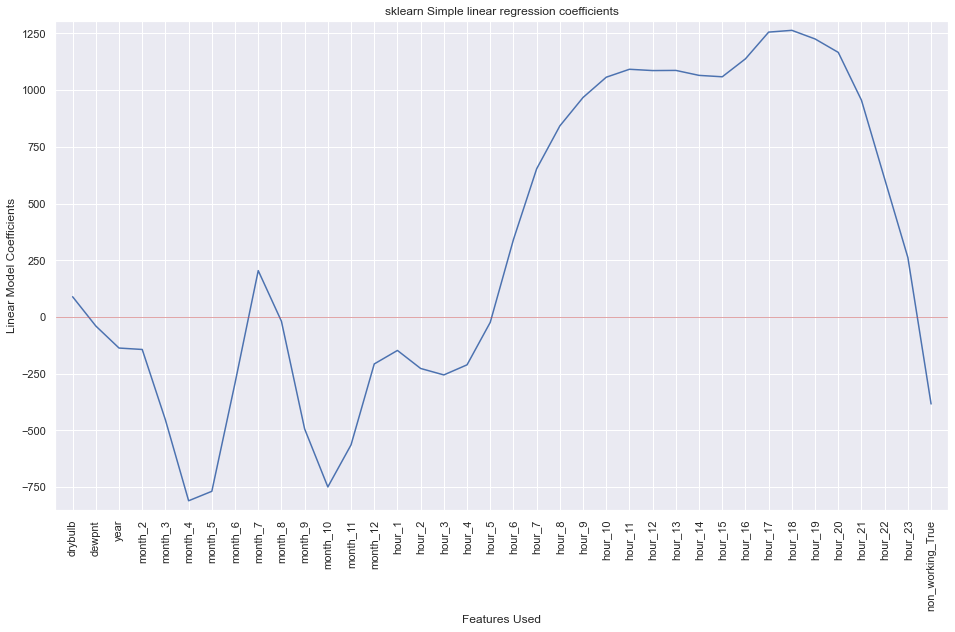

In [263]:
# Plotting the coefficients to check the importance of each coefficient 

# Plot the coefficients
plt.figure(figsize=(16, 9))
plt.plot(range(len(X_train.columns)), lm.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('sklearn Simple linear regression coefficients')
plt.ylabel('Linear Model Coefficients')
plt.xlabel('Features Used')

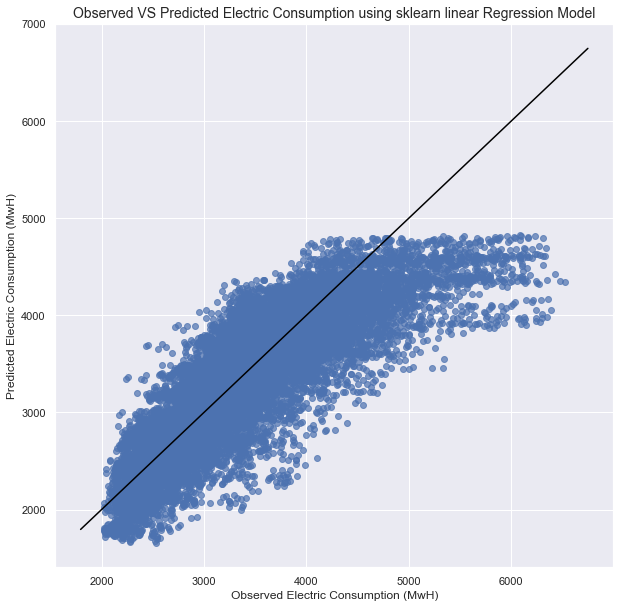

In [264]:
# Plotting lm.predict(X) vs observed energy consumption

PredTrueReg(lm.predict(X_test), y_test, model_name = 'sklearn linear Regression Model')

In [265]:
error_metrics(lm.predict(X_train), y_train, model_name = 'sklearn linear Regression Model with Scaling', test = False)

Error metrics for sklearn linear Regression Model with Scaling 

Root Mean Squared Error (RMSE): 404.919
Mean Absolute Error (MAE): 299.61
Mean Absolute Percentage Error (MAPE): 8.143 %
Variance Score (R2): 0.74


In [266]:
# on test set
error_metrics(lm.predict(X_test), y_test, model_name = 'sklearn linear Regression Model with Scaling', test = True)

Error metrics for sklearn linear Regression Model with Scaling 

Root Mean Squared Error (RMSE): 442.891
Mean Absolute Error (MAE): 331.248
Mean Absolute Percentage Error (MAPE): 9.382 %
Variance Score (R2): 0.673


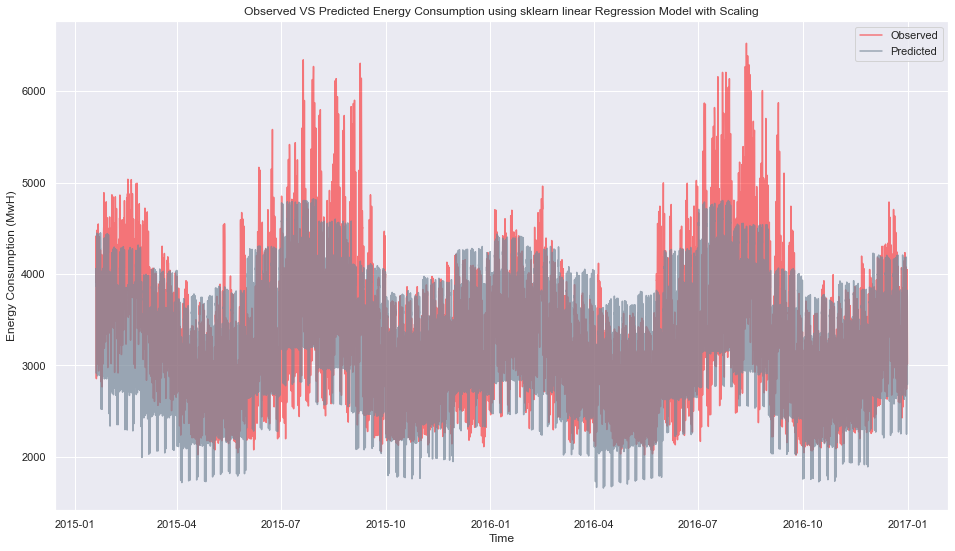

In [267]:
# Plotting the predicted values with the original time series (test set)
PlotPredictedTS(y_test, lm.predict(X_test), model_name='sklearn linear Regression Model with Scaling')

### 3.1.1 Baseline Forecast

In [268]:
# Baseline Persistent Forecast (One Year Before)
error_metrics(CT_lin.loc[X_test.index.shift(-8760, freq='h'), 'demand'], y_test, model_name='Baseline Persistent Forecast (One Year Before)', test=True)

Error metrics for Baseline Persistent Forecast (One Year Before) 

Root Mean Squared Error (RMSE): 513.197
Mean Absolute Error (MAE): 379.745
Mean Absolute Percentage Error (MAPE): 10.765 %
Variance Score (R2): 0.561


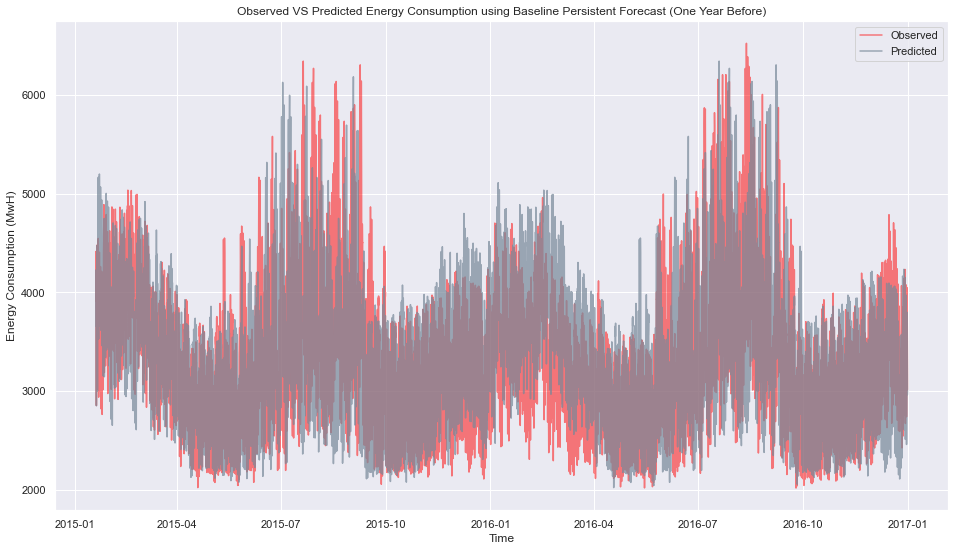

In [269]:
PlotPredictedTS(y_test, CT_lin.loc[X_test.index.shift(-8760, freq='h'), 'demand'].to_numpy(), model_name='Baseline Persistent Forecast (One Year Before)')

In [270]:
# Baseline Persistent Forecast (One Hour Before)
error_metrics(CT_lin.loc[X_test.index.shift(-1, freq='h'), 'demand'], y_test, model_name='Baseline Persistent Forecast (One Hour Before)', test=True)

Error metrics for Baseline Persistent Forecast (One Hour Before) 

Root Mean Squared Error (RMSE): 184.311
Mean Absolute Error (MAE): 141.312
Mean Absolute Percentage Error (MAPE): 4.232 %
Variance Score (R2): 0.943


In [271]:
# Baseline Persistent Forecast (One Week Before)
error_metrics(CT_lin.loc[X_test.index.shift(-168, freq='h'), 'demand'], y_test, model_name='Baseline Persistent Forecast (One Week Before)', test=True)

Error metrics for Baseline Persistent Forecast (One Week Before) 

Root Mean Squared Error (RMSE): 465.045
Mean Absolute Error (MAE): 328.765
Mean Absolute Percentage Error (MAPE): 9.222 %
Variance Score (R2): 0.64


## 3.2 Ridge Regression

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Features Used')

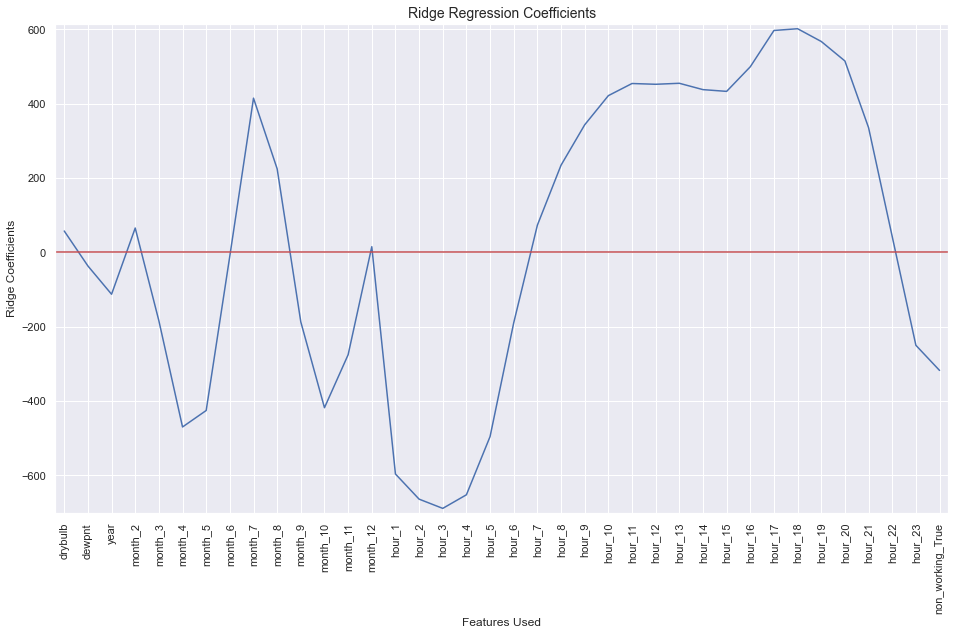

In [272]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.2, normalize=True)

ridge.fit(X_train, y_train)

plt.figure(figsize=(16,9))
sns.lineplot(range(len(X_train.columns)), ridge.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.01)
plt.axhline(0, color='r')
plt.title('Ridge Regression Coefficients', fontsize=14)
plt.ylabel('Ridge Coefficients')
plt.xlabel('Features Used')


Text(0.5, 0, 'Ridge Predicted Demand (MwH)')

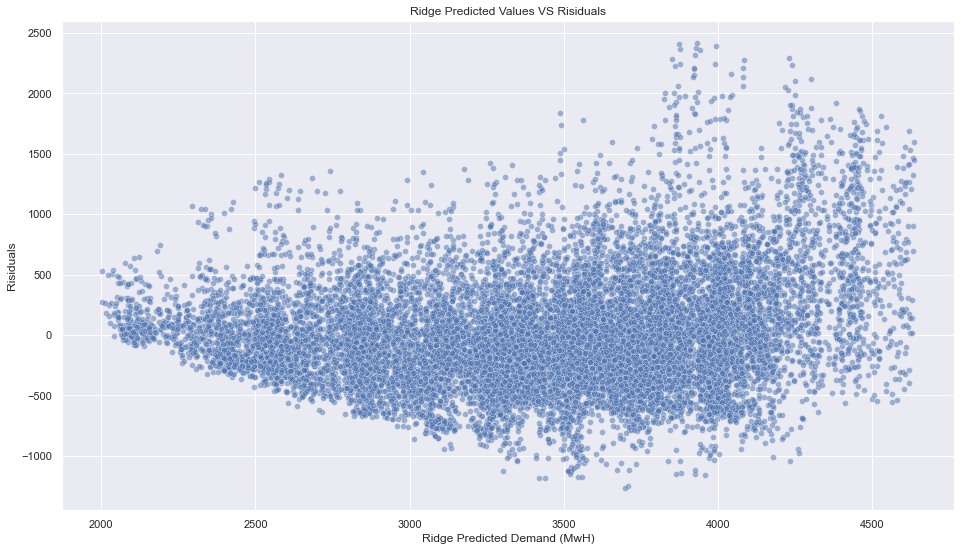

In [273]:
ris = y_test - (ridge.predict(X_test))
plt.figure(figsize=(16,9))
sns.scatterplot(x=(ridge.predict(X_test)), y=ris, alpha=0.5)
plt.title('Ridge Predicted Values VS Risiduals')
plt.ylabel('Risiduals')
plt.xlabel('Ridge Predicted Demand (MwH)')

In [274]:
# Ridge Regression Error Metrics (Training)
error_metrics(ridge.predict(X_train), y_train, model_name='Ridge Regression (Scaled)', test=False)

# Ridge Regression Error Metrics (Test)
error_metrics(ridge.predict(X_test), y_test, model_name='Ridge Regression (Scaled)', test=True)

Error metrics for Ridge Regression (Scaled) 

Root Mean Squared Error (RMSE): 439.573
Mean Absolute Error (MAE): 321.601
Mean Absolute Percentage Error (MAPE): 8.828 %
Variance Score (R2): 0.693
Error metrics for Ridge Regression (Scaled) 

Root Mean Squared Error (RMSE): 456.038
Mean Absolute Error (MAE): 342.424
Mean Absolute Percentage Error (MAPE): 9.827 %
Variance Score (R2): 0.653


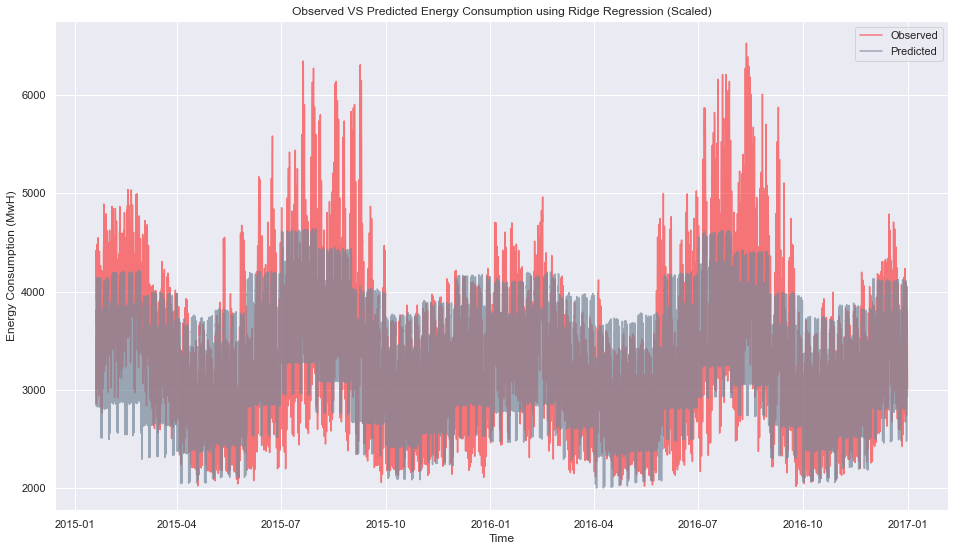

In [275]:
PlotPredictedTS(y_test, ridge.predict(X_test), model_name='Ridge Regression (Scaled)')

## 3.3 Reducing the feature space

In [276]:
CT = df.copy()
CT.head()

,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday,trend,non_working
ts,,,,,,,,,,,,,,
2004-01-01 00:00:00,CT,3126.0,33.0,26.0,2004-01-01,2004,1,0,Thu,1,False,True,7344.0,True
2004-01-01 01:00:00,CT,2945.0,34.0,26.0,2004-01-01,2004,1,1,Thu,1,False,True,7345.0,True
2004-01-01 02:00:00,CT,2804.0,40.0,26.0,2004-01-01,2004,1,2,Thu,1,False,True,7346.0,True
2004-01-01 03:00:00,CT,2729.0,38.0,23.0,2004-01-01,2004,1,3,Thu,1,False,True,7347.0,True
2004-01-01 04:00:00,CT,2722.0,37.0,21.0,2004-01-01,2004,1,4,Thu,1,False,True,7348.0,True


In [277]:
def season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

In [278]:
CT['season'] = CT.month.apply(season)
CT.head()

,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday,trend,non_working,season
ts,,,,,,,,,,,,,,,
2004-01-01 00:00:00,CT,3126.0,33.0,26.0,2004-01-01,2004,1,0,Thu,1,False,True,7344.0,True,Winter
2004-01-01 01:00:00,CT,2945.0,34.0,26.0,2004-01-01,2004,1,1,Thu,1,False,True,7345.0,True,Winter
2004-01-01 02:00:00,CT,2804.0,40.0,26.0,2004-01-01,2004,1,2,Thu,1,False,True,7346.0,True,Winter
2004-01-01 03:00:00,CT,2729.0,38.0,23.0,2004-01-01,2004,1,3,Thu,1,False,True,7347.0,True,Winter
2004-01-01 04:00:00,CT,2722.0,37.0,21.0,2004-01-01,2004,1,4,Thu,1,False,True,7348.0,True,Winter


In [279]:
def TimeOfDay(x):
    if x in (list(np.arange(7,13))):
        return 'morning'
    elif x in (list(np.arange(13,16))):
        return 'afternoon'
    elif x in (list(np.arange(16,22))):
        return 'evening'
    else:
        return 'night'

In [280]:
CT['time_of_day'] = CT['hour'].apply(TimeOfDay)
CT.head()

,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday,trend,non_working,season,time_of_day
ts,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,CT,3126.0,33.0,26.0,2004-01-01,2004,1,0,Thu,1,False,True,7344.0,True,Winter,night
2004-01-01 01:00:00,CT,2945.0,34.0,26.0,2004-01-01,2004,1,1,Thu,1,False,True,7345.0,True,Winter,night
2004-01-01 02:00:00,CT,2804.0,40.0,26.0,2004-01-01,2004,1,2,Thu,1,False,True,7346.0,True,Winter,night
2004-01-01 03:00:00,CT,2729.0,38.0,23.0,2004-01-01,2004,1,3,Thu,1,False,True,7347.0,True,Winter,night
2004-01-01 04:00:00,CT,2722.0,37.0,21.0,2004-01-01,2004,1,4,Thu,1,False,True,7348.0,True,Winter,night


In [281]:
cols = ['month', 'day_of_year', 'hour', 'day_of_week', 'season', 'holiday', 'non_working', 'time_of_day']

for c in cols:
    CT[c] = CT[c].astype('category')

In [282]:
CT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113976 entries, 2004-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   zone         113976 non-null  object  
 1   demand       113976 non-null  float64 
 2   drybulb      113976 non-null  float64 
 3   dewpnt       113976 non-null  float64 
 4   date         113976 non-null  object  
 5   year         113976 non-null  int64   
 6   month        113976 non-null  category
 7   hour         113976 non-null  category
 8   day_of_week  113976 non-null  category
 9   day_of_year  113976 non-null  category
 10  weekend      113976 non-null  bool    
 11  holiday      113976 non-null  category
 12  trend        113976 non-null  float64 
 13  non_working  113976 non-null  category
 14  season       113976 non-null  category
 15  time_of_day  113976 non-null  category
dtypes: bool(1), category(8), float64(4), int64(1), object(2)
m

In [283]:
regCols = ['demand', 'year', 'time_of_day', 'non_working', 'drybulb', 'dewpnt', 'season']
CT1_lin = pd.get_dummies(CT[regCols], drop_first = True)
CT1_lin.head()

,demand,year,drybulb,dewpnt,time_of_day_evening,time_of_day_morning,time_of_day_night,non_working_True,season_Spring,season_Summer,season_Winter
ts,,,,,,,,,,,
2004-01-01 00:00:00,3126.0,2004,33.0,26.0,0,0,1,1,0,0,1
2004-01-01 01:00:00,2945.0,2004,34.0,26.0,0,0,1,1,0,0,1
2004-01-01 02:00:00,2804.0,2004,40.0,26.0,0,0,1,1,0,0,1
2004-01-01 03:00:00,2729.0,2004,38.0,23.0,0,0,1,1,0,0,1
2004-01-01 04:00:00,2722.0,2004,37.0,21.0,0,0,1,1,0,0,1


In [284]:
cols_to_transform = ['drybulb', 'dewpnt', 'year']
X_train, X_test, y_train, y_test = TrainTestSplit(CT1_lin, scale = True, cols_to_transform=cols_to_transform, include_test_scale=False)

## 3.4 Elastic Net Regression

In [285]:
from turtle import color
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

param_grid = {'l1_ratio': np.linspace(0, 1, 50), 'alpha': np.logspace(-2, 0, 30)}
elastic_net = ElasticNet()
tsCV = TimeSeriesSplit(n_splits=5)
gm_cv = GridSearchCV(elastic_net, param_grid, cv=tsCV)

gm_cv.fit(X_train, y_train)

y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Tuned ElasticNet l1 ratio: {gm_cv.best_params_}')
print(f'Tuned ElasticNet R squared: {r2}')
print(f'Tuned ElasticNet RMSE: {np.sqrt(mse)}')

elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
elastic_net_opt.fit(X_train, y_train)


/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2046365652.327398, tolerance: 1106553.7021785553

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4066036571.7406025, tolerance: 2149053.8742508185

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5693052865.408721, tolerance: 3035260.3958810978

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase 

Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 0.9795918367346939}
Tuned ElasticNet R squared: 0.5717716335147331
Tuned ElasticNet RMSE: 506.90916784098044


ElasticNet(l1_ratio=0.9795918367346939)

Text(0.5, 0, 'Features Used')

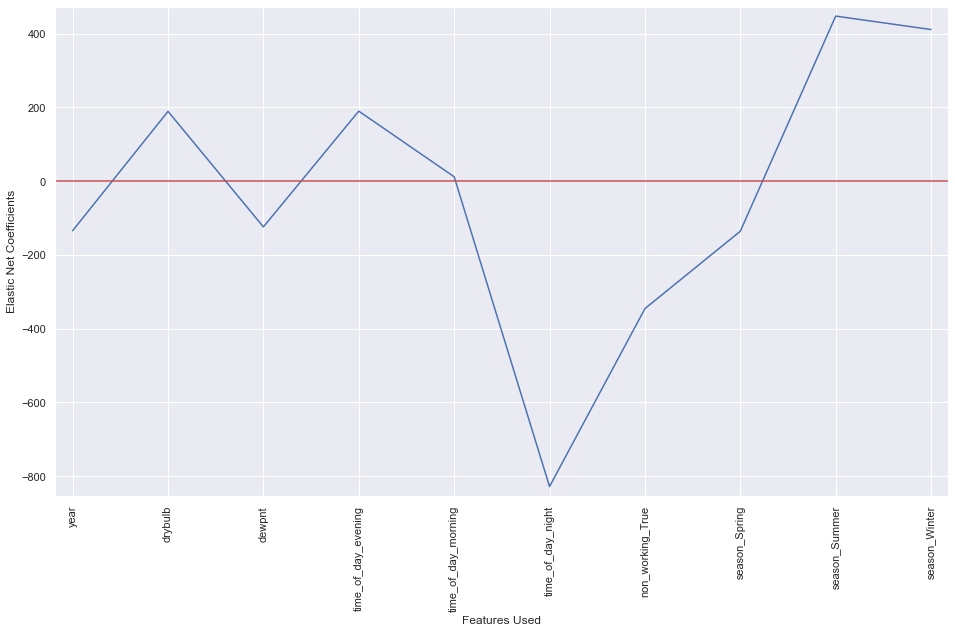

In [286]:
plt.figure(figsize=(16,9))
sns.lineplot(x=(range(len(X_train.columns))), y=elastic_net_opt.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.02)
plt.axhline(0, color='r')
plt.ylabel('Elastic Net Coefficients')
plt.xlabel('Features Used')

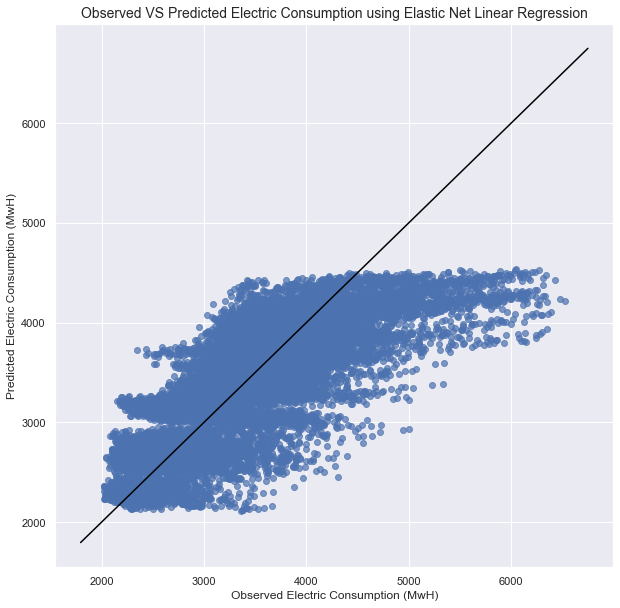

In [287]:
PredTrueReg(elastic_net_opt.predict(X_test), y_test, model_name='Elastic Net Linear Regression')

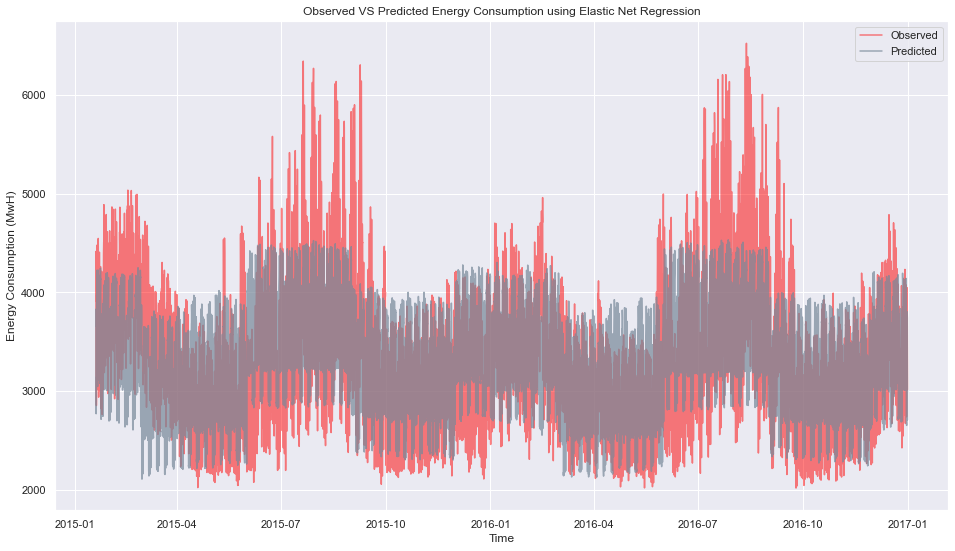

In [288]:
PlotPredictedTS(y_test, elastic_net_opt.predict(X_test), model_name='Elastic Net Regression')

In [289]:
# Elastic Net Error Metrics (Train)
error_metrics(elastic_net_opt.predict(X_train), y_train, model_name='Elastic Net with reduced feature space', test=False)

# Elastic Net Error Metrics (Test)
error_metrics(elastic_net_opt.predict(X_test), y_test, model_name='Elastic Net with reduced feature space', test=True)

Error metrics for Elastic Net with reduced feature space 

Root Mean Squared Error (RMSE): 477.291
Mean Absolute Error (MAE): 363.237
Mean Absolute Percentage Error (MAPE): 10.107 %
Variance Score (R2): 0.638
Error metrics for Elastic Net with reduced feature space 

Root Mean Squared Error (RMSE): 506.909
Mean Absolute Error (MAE): 387.795
Mean Absolute Percentage Error (MAPE): 11.146 %
Variance Score (R2): 0.572


# 4. Random Forest Regression

In [290]:
from sklearn.ensemble import RandomForestRegressor

In [291]:
estimators = list(np.linspace(10, 300, 10, endpoint=True, dtype=int))
features = ['auto', 'sqrt']
depth = list(range(1, 6))

random_grid = {'n_estimators': estimators, 'max_features': features, 'max_depth': depth}
print(random_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [292]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

tscv = TimeSeriesSplit(n_splits=5)

rf_random = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, cv=tscv, verbose=2, n_jobs=-1)

rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 138, 'max_features': 'auto', 'max_depth': 5}

In [293]:
rf_random.score(X_train, y_train)

0.8004361972745969

In [294]:
rf_random.score(X_test, y_test)

0.7065891601457464

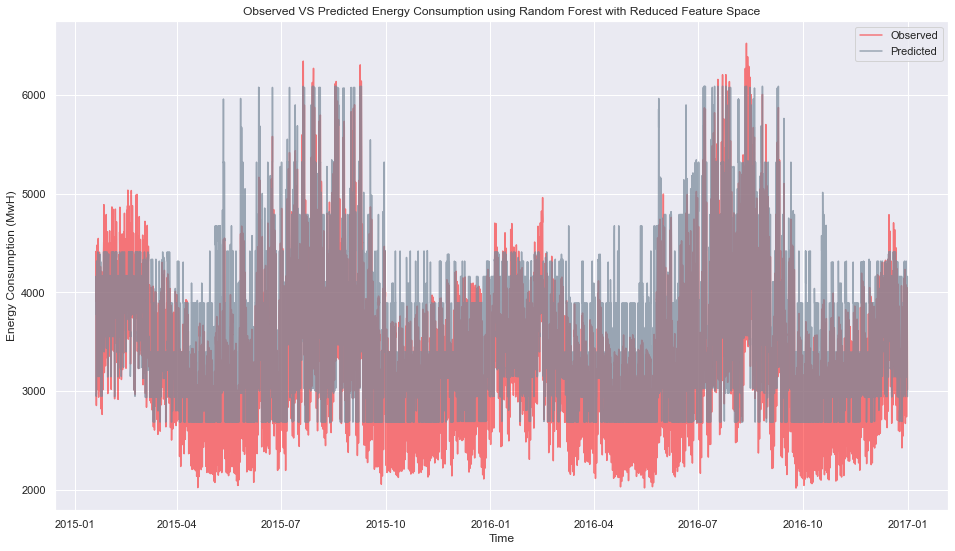

In [295]:
PlotPredictedTS(y_test, rf_random.predict(X_test), model_name='Random Forest with Reduced Feature Space')

In [296]:
error_metrics(rf_random.predict(X_train), y_train, model_name='Random Forest with Reduced Feature Space', test=False)

error_metrics(rf_random.predict(X_test), y_test, model_name='Random Forest with Reduced Feature Space', test=True)

Error metrics for Random Forest with Reduced Feature Space 

Root Mean Squared Error (RMSE): 354.573
Mean Absolute Error (MAE): 279.891
Mean Absolute Percentage Error (MAPE): 7.91 %
Variance Score (R2): 0.8
Error metrics for Random Forest with Reduced Feature Space 

Root Mean Squared Error (RMSE): 419.595
Mean Absolute Error (MAE): 351.672
Mean Absolute Percentage Error (MAPE): 10.933 %
Variance Score (R2): 0.707


# 5. Adding lags as X variables (Elastic Net & Random Forest)

## 5.1 Adding the lagged demand to our data

In [297]:
CT1_lin.head()

,demand,year,drybulb,dewpnt,time_of_day_evening,time_of_day_morning,time_of_day_night,non_working_True,season_Spring,season_Summer,season_Winter
ts,,,,,,,,,,,
2004-01-01 00:00:00,3126.0,2004,33.0,26.0,0,0,1,1,0,0,1
2004-01-01 01:00:00,2945.0,2004,34.0,26.0,0,0,1,1,0,0,1
2004-01-01 02:00:00,2804.0,2004,40.0,26.0,0,0,1,1,0,0,1
2004-01-01 03:00:00,2729.0,2004,38.0,23.0,0,0,1,1,0,0,1
2004-01-01 04:00:00,2722.0,2004,37.0,21.0,0,0,1,1,0,0,1


In [298]:
# Creating the lag variables | lag1 is demand for the previous hour, lag2 is demand for two hours before, and so on
for i in range(24):
    CT1_lin['lag'+str(i+1)] = CT1_lin['demand'].shift(i+1)

In [299]:
lagged_demand = CT1_lin.dropna()
lagged_demand.head()

,demand,year,drybulb,dewpnt,time_of_day_evening,time_of_day_morning,time_of_day_night,non_working_True,season_Spring,season_Summer,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
ts,,,,,,,,,,,,,,,,,,,,,
2004-01-02 00:00:00,2970.0,2004,27.0,24.0,0,0,1,0,0,0,...,3299.0,3106.0,2954.0,2893.0,2789.0,2722.0,2729.0,2804.0,2945.0,3126.0
2004-01-02 01:00:00,2854.0,2004,28.0,25.0,0,0,1,0,0,0,...,3467.0,3299.0,3106.0,2954.0,2893.0,2789.0,2722.0,2729.0,2804.0,2945.0
2004-01-02 02:00:00,2787.0,2004,28.0,25.0,0,0,1,0,0,0,...,3565.0,3467.0,3299.0,3106.0,2954.0,2893.0,2789.0,2722.0,2729.0,2804.0
2004-01-02 03:00:00,2767.0,2004,29.0,26.0,0,0,1,0,0,0,...,3550.0,3565.0,3467.0,3299.0,3106.0,2954.0,2893.0,2789.0,2722.0,2729.0
2004-01-02 04:00:00,2806.0,2004,28.0,26.0,0,0,1,0,0,0,...,3480.0,3550.0,3565.0,3467.0,3299.0,3106.0,2954.0,2893.0,2789.0,2722.0


## 5.2 Running Elastic Net Regression on lagged data

In [300]:
TransformColumns = ['drybulb', 'dewpnt', 'year']
lagList = []
for i in range(24):
    x = 'lag'+str(i+1)
    lagList.append(x)

TransformColumns = TransformColumns + lagList

In [301]:
X_train, X_test, y_train, y_test = TrainTestSplit(lagged_demand, scale=True, cols_to_transform=TransformColumns)

In [302]:
laggedElasticNet = ElasticNet(l1_ratio=1, alpha=0.2)
laggedElasticNet.fit(X_train, y_train)

/Users/alnoaimi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10001577.541816652, tolerance: 6102652.025642119



ElasticNet(alpha=0.2, l1_ratio=1)

Text(0.5, 0, 'Features Used')

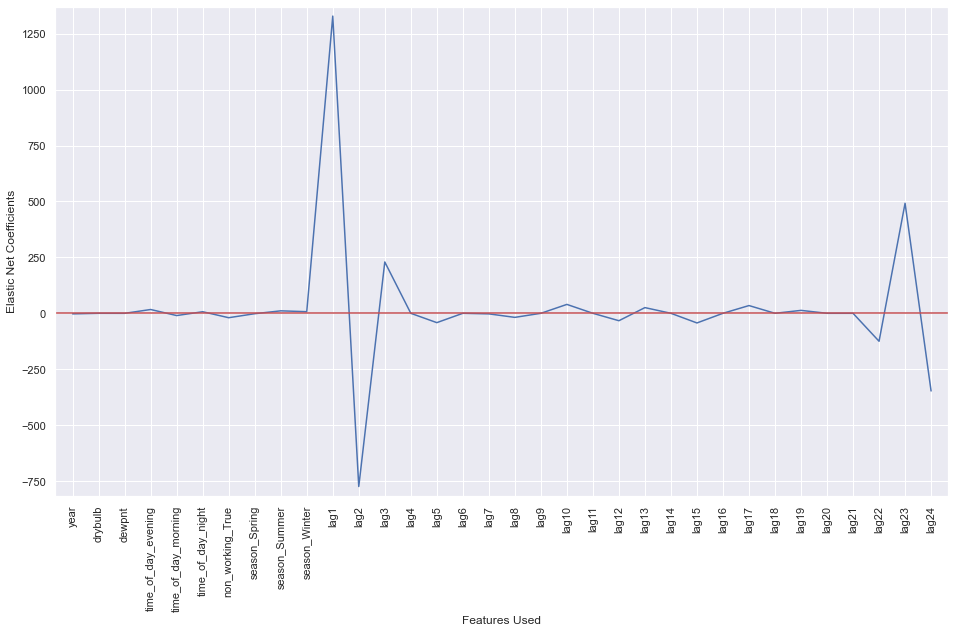

In [303]:
plt.figure(figsize=(16,9))
sns.lineplot(x=(range(len(X_train.columns))), y=laggedElasticNet.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.02)
plt.axhline(0, color='r')
plt.ylabel('Elastic Net Coefficients')
plt.xlabel('Features Used')

## 5.3 Running Random Forest on Lagged Data

In [304]:
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

rflag = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, cv=tscv, verbose=2, n_jobs=-1)

rflag.fit(X_train, y_train)
rflag.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 267, 'max_features': 'auto', 'max_depth': 5}

In [305]:
print('Random Forest | Lagged')
error_metrics(rflag.predict(X_train), y_train, model_name='Random Forest | Lagged', test=False)
error_metrics(rflag.predict(X_test), y_test, model_name='Random Forest | Lagged', test=True)

print('Elastic Net | Lagged')
error_metrics(laggedElasticNet.predict(X_train), y_train, model_name='Elastic Net | Lagged', test=False)
error_metrics(laggedElasticNet.predict(X_test), y_test, model_name='Elastic Net | Lagged', test=True)

Random Forest | Lagged
Error metrics for Random Forest | Lagged 

Root Mean Squared Error (RMSE): 143.775
Mean Absolute Error (MAE): 109.74
Mean Absolute Percentage Error (MAPE): 3.021 %
Variance Score (R2): 0.967
Error metrics for Random Forest | Lagged 

Root Mean Squared Error (RMSE): 140.43
Mean Absolute Error (MAE): 110.05
Mean Absolute Percentage Error (MAPE): 3.299 %
Variance Score (R2): 0.967
Elastic Net | Lagged
Error metrics for Elastic Net | Lagged 

Root Mean Squared Error (RMSE): 62.478
Mean Absolute Error (MAE): 43.235
Mean Absolute Percentage Error (MAPE): 1.18 %
Variance Score (R2): 0.994
Error metrics for Elastic Net | Lagged 

Root Mean Squared Error (RMSE): 53.09
Mean Absolute Error (MAE): 37.613
Mean Absolute Percentage Error (MAPE): 1.092 %
Variance Score (R2): 0.995


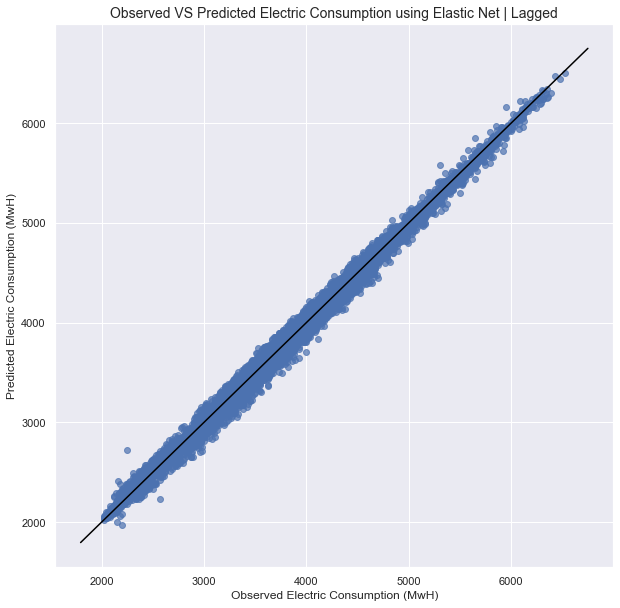

In [306]:
PredTrueReg(laggedElasticNet.predict(X_test), y_test, model_name='Elastic Net | Lagged')

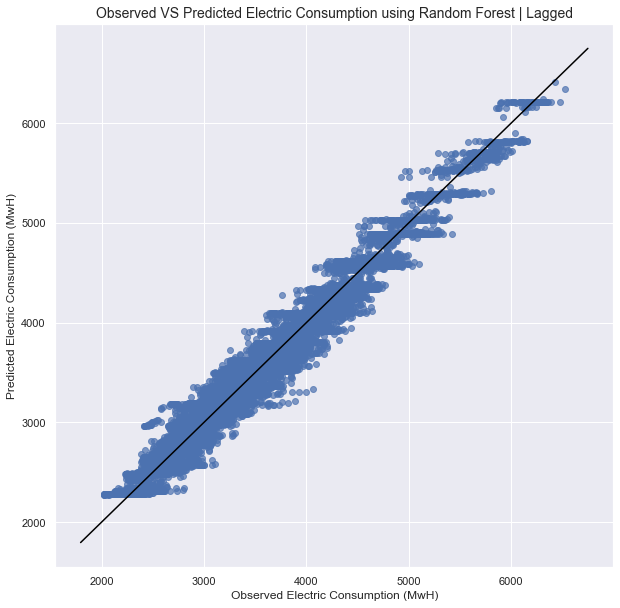

In [307]:
PredTrueReg(rflag.predict(X_test), y_test, model_name='Random Forest | Lagged')

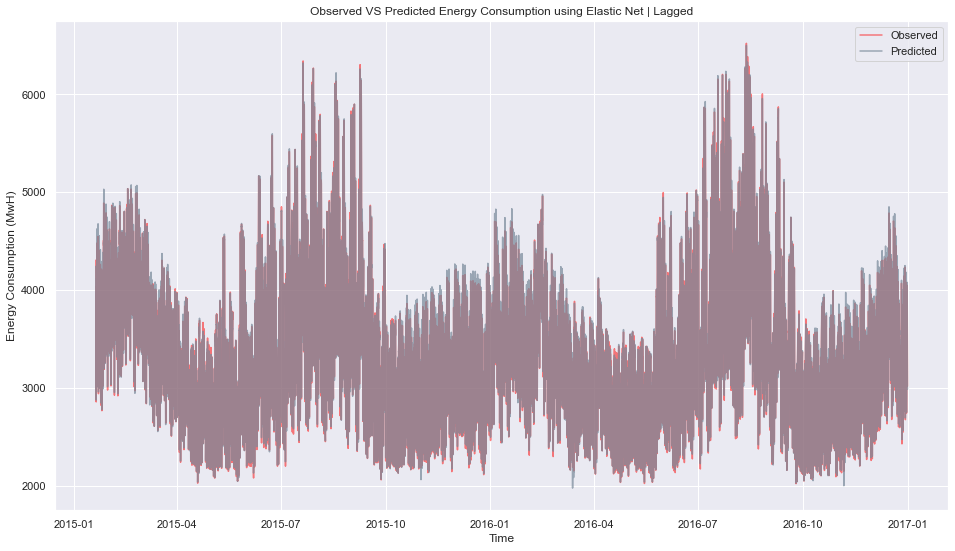

In [308]:
PlotPredictedTS(y_test, laggedElasticNet.predict(X_test), model_name='Elastic Net | Lagged')

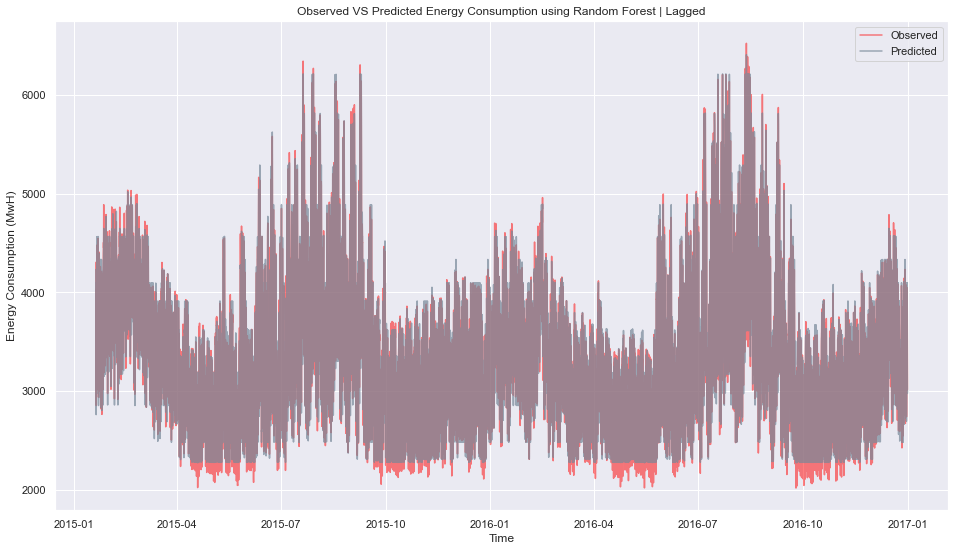

In [309]:
PlotPredictedTS(y_test, rflag.predict(X_test), model_name='Random Forest | Lagged')

# 6. Time Series and Features and Models

## 6.1 Basic Time Series Structure, Stationarity, and Auto Correlation

In [311]:
demandTS = pd.DataFrame(CT1_lin['demand'], columns=['demand'])
demandTS.tail()

,demand
ts,
2016-12-31 19:00:00,3744.918
2016-12-31 20:00:00,3558.586
2016-12-31 21:00:00,3378.466
2016-12-31 22:00:00,3195.386
2016-12-31 23:00:00,3016.453


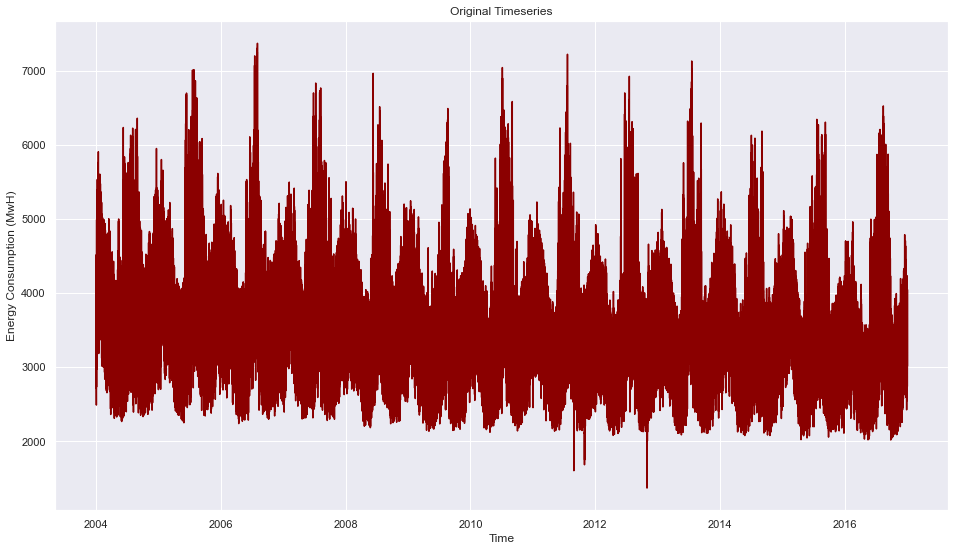

In [314]:
PlotTS(demandTS['demand'], title='Original Timeseries')

In [315]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

<ipython-input-332-e9dfbbaa3896>:1: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



ts
2004-01-01 00:00:00   -539.182164
2004-01-01 01:00:00   -684.756011
2004-01-01 02:00:00   -757.329593
2004-01-01 03:00:00   -781.153009
2004-01-01 04:00:00   -741.309457
Name: seasonal, dtype: float64


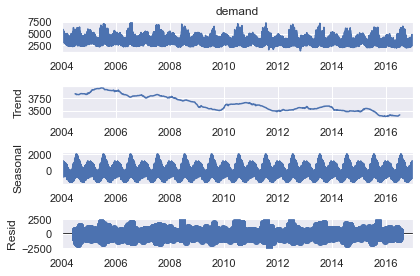

In [332]:
decompose = sm.tsa.seasonal_decompose(demandTS['demand'], freq=8760)
print(decompose.seasonal.head())

p = decompose.plot()

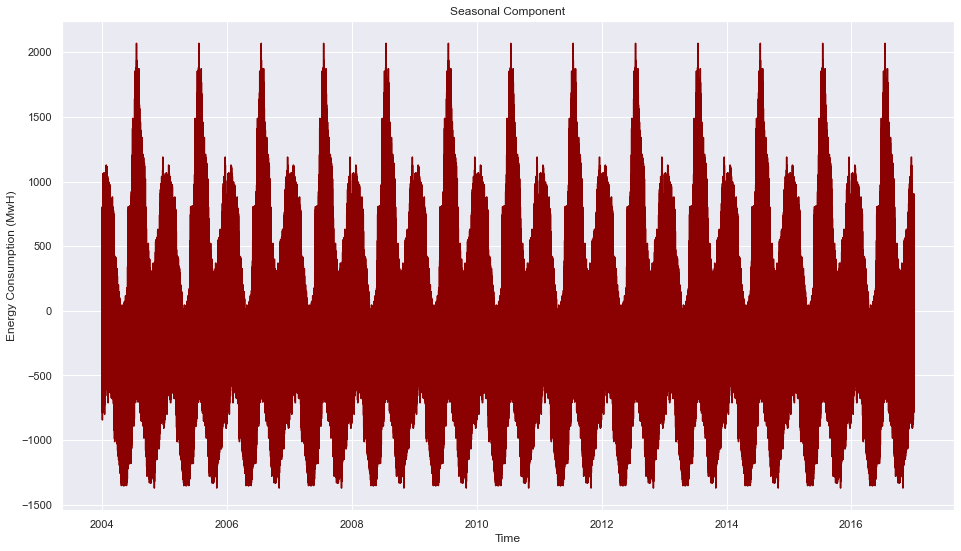

In [333]:
demandTS['seasonal'] = decompose.seasonal
PlotTS(demandTS['seasonal'], title='Seasonal Component')

<AxesSubplot:xlabel='ts'>

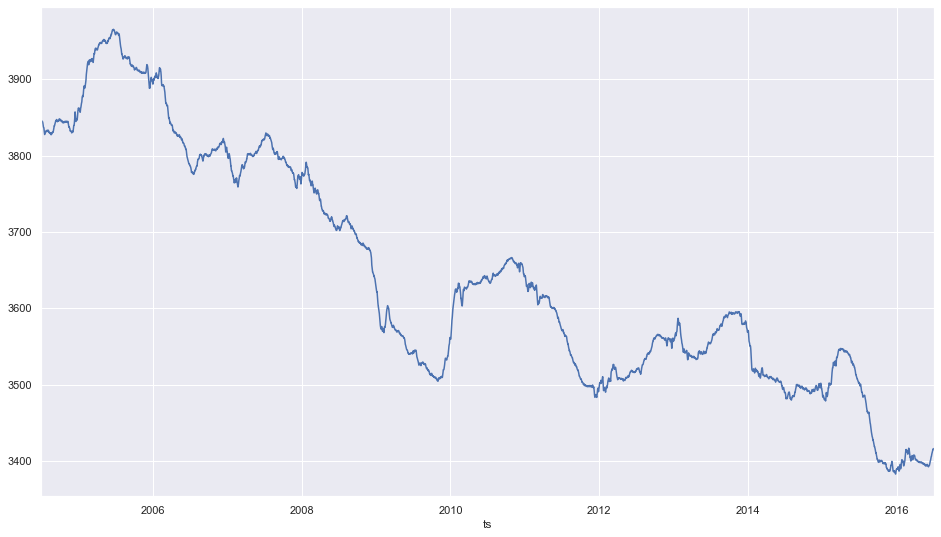

In [334]:
demandTS['trend'] = decompose.trend
demandTS['trend'].dropna().plot(figsize=(16,9))

<AxesSubplot:xlabel='ts'>

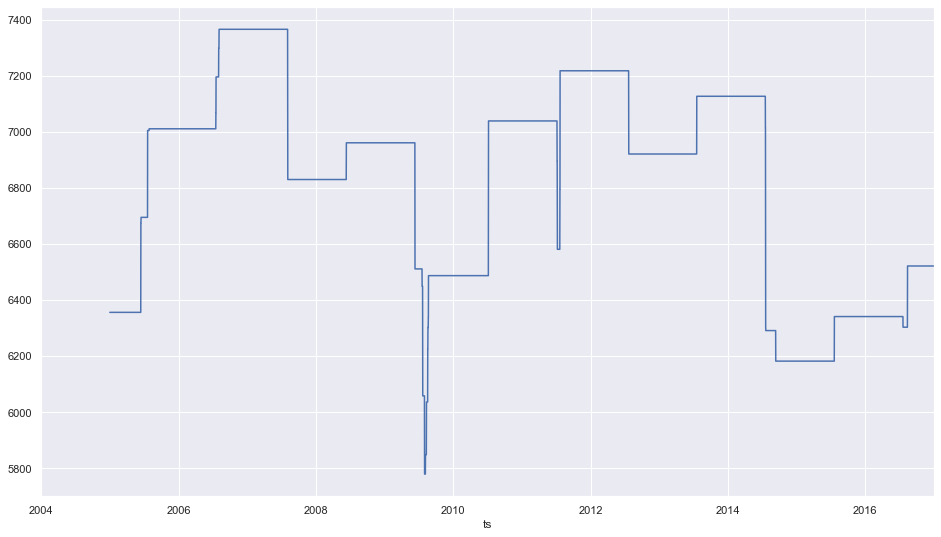

In [337]:
df['demand'].rolling(window=8760).max().plot(figsize=(16,9))

### 6.1.1 Dicky Fuller Test for Stationarity

In [338]:
from statsmodels.tsa.stattools import adfuller

def run_adfuller(ts):
    results = adfuller(ts)
    print('t-stat', results[0])
    print('p-value', results[1])
    print('#lags used', results[2])
    print('critical values', results[4])

In [ ]:
print()